# Integrated Gradients

## Setup

In [549]:
# !pip install torchsummary

In [550]:
import time
import os
import io
import requests

import numpy as np
import pandas as pd

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.models as models
from torchvision.datasets import ImageNet
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

from PIL import Image
import matplotlib.pylab as plt

## Download a pretrained image classifier

In [551]:
model = models.resnet18(pretrained=True)
model.eval()
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [552]:
import urllib

def load_imagenet_labels(file_path):
    # download the labels file
    labels_file = urllib.request.urlretrieve(file_path, 'ImageNetLabels.txt')[0]
    with open(labels_file, 'r') as reader:
        labels = reader.read().splitlines()
    return np.array(labels)

imagenet_labels = load_imagenet_labels('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels

array(['background', 'tench', 'goldfish', ..., 'bolete', 'ear',
       'toilet tissue'], dtype='<U30')

## Load and preprocess images

In [553]:
preprocess = transforms.Compose([
   transforms.Resize(256),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   transforms.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
   )
])

def read_image(file_name):
    resp = requests.get(file_name)
    image = Image.open(io.BytesIO(resp.content))
    image = preprocess(image).unsqueeze(0)
    print(image.shape)
    return image

In [554]:
img_url = {
    'Fireboat': 'http://storage.googleapis.com/download.tensorflow.org/example_images/San_Francisco_fireboat_showing_off.jpg',
    'Giant Panda': 'http://storage.googleapis.com/download.tensorflow.org/example_images/Giant_Panda_2.jpeg',
    'Dog': 'https://github.com/pytorch/hub/raw/master/images/dog.jpg'
}

img_name_tensors = {name: read_image(img_path) for (name, img_path) in img_url.items()}

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


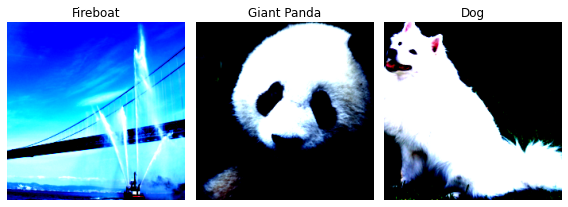

In [555]:
plt.figure(figsize=(8, 8))
for n, (name, img_tensor) in enumerate(img_name_tensors.items()):
    img_tensor_plot = img_tensor.squeeze(0).permute(1, 2, 0)
    ax = plt.subplot(1, len(img_name_tensors.keys()), n+1)
    ax.imshow(img_tensor_plot)
    ax.set_title(name)
    ax.axis('off')
plt.tight_layout()

## Classify images

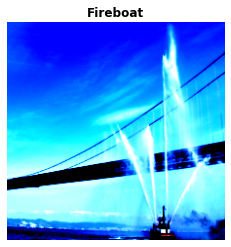

file: 100.0%


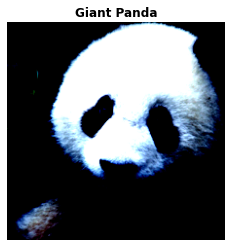

lesser panda: 99.3%


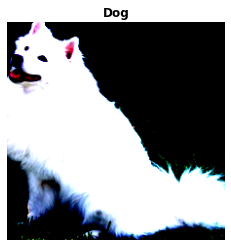

Great Pyrenees: 88.5%


In [556]:
for (name, img_tensor) in img_name_tensors.items():
    output = model(img_tensor)

    _, pred = output.max(1)
    probs = torch.nn.functional.softmax(output, dim=1)
    pred_score = probs[0][pred].item()

    class_label = imagenet_labels[pred]
    
    img_tensor_plot = img_tensor.squeeze(0).permute(1, 2, 0)
    plt.imshow(img_tensor_plot)
    plt.title(name, fontweight='bold')
    plt.axis('off')
    plt.show()
    print(f'{class_label}: {pred_score:0.1%}')

## Calculate Integrated Gradients

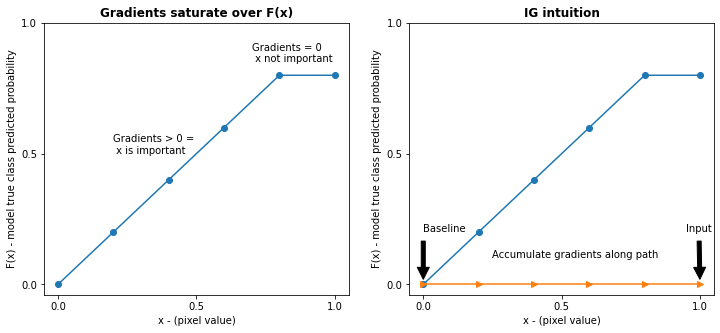

In [557]:
def f(x):
    """A simplified model function."""
    return torch.where(x < 0.8, x, torch.tensor(0.8))

def interpolated_path(x):
    """A straight line path."""
    return torch.zeros_like(x)

x = torch.linspace(start=0.0, end=1.0, steps=6)
y = f(x)

fig = plt.figure(figsize=(12, 5))
ax0 = fig.add_subplot(121)
ax0.plot(x, f(x), marker='o')
ax0.set_title('Gradients saturate over F(x)', fontweight='bold')
ax0.text(0.2, 0.5, 'Gradients > 0 = \n x is important')
ax0.text(0.7, 0.85, 'Gradients = 0 \n x not important')
ax0.set_yticks(torch.arange(0, 1.5, 0.5))
ax0.set_xticks(torch.arange(0, 1.5, 0.5))
ax0.set_ylabel('F(x) - model true class predicted probability')
ax0.set_xlabel('x - (pixel value)')

ax1 = fig.add_subplot(122)
ax1.plot(x, f(x), marker='o')
ax1.plot(x, interpolated_path(x), marker='>')
ax1.set_title('IG intuition', fontweight='bold')
ax1.text(0.25, 0.1, 'Accumulate gradients along path')
ax1.set_ylabel('F(x) - model true class predicted probability')
ax1.set_xlabel('x - (pixel value)')
ax1.set_yticks(torch.arange(0, 1.5, 0.5))
ax1.set_xticks(torch.arange(0, 1.5, 0.5))
ax1.annotate('Baseline', xy=(0.0, 0.0), xytext=(0.0, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.1))
ax1.annotate('Input', xy=(1.0, 0.0), xytext=(0.95, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.show()

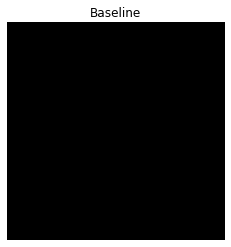

In [558]:
baseline = torch.zeros(size=(224,224,3))

plt.imshow(baseline)
plt.title("Baseline")
plt.axis('off')
plt.show()

### Interpolate images

In [559]:
m_steps = 50
alphas = torch.linspace(start=0.0, end=1.0, steps=m_steps+1)

def interpolate_images(baseline, image, alphas):
    alphas_x = alphas.view(-1, 1, 1, 1)
    baseline_x = baseline.unsqueeze(0)
    input_x = image.permute(0,2,3,1)
    delta = input_x - baseline_x
    images = baseline_x + alphas_x * delta
    return images

interpolated_images = interpolate_images(baseline=baseline, image=img_name_tensors['Fireboat'], alphas=alphas)

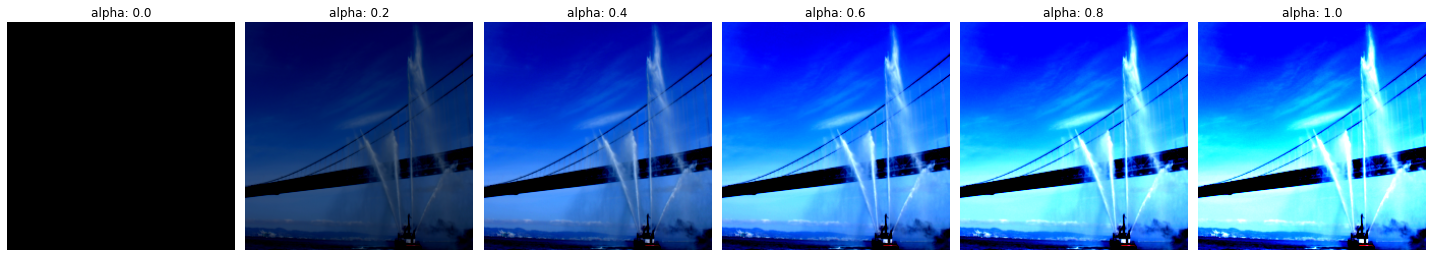

In [560]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
    i += 1
    plt.subplot(1, len(alphas[0::10]), i)
    plt.title(f'alpha: {alpha:.1f}')
    plt.imshow(image)
    plt.axis('off')

plt.tight_layout();

## Compute Gradients

In [561]:
def compute_gradients(images, target_class_idx):
    images = images.requires_grad_()
    logits = model(images.permute(0,3,1,2))
    
    probs = F.softmax(logits, dim=-1)[:, target_class_idx]
    probs.sum().backward(retain_graph=True) # FIXME: check if sum is better than mean ????
    gradients = images.grad
    
    return gradients

path_gradients = compute_gradients(images=interpolated_images, target_class_idx=555)
print(path_gradients.shape)

torch.Size([51, 224, 224, 3])


### Visualizing gradient saturation

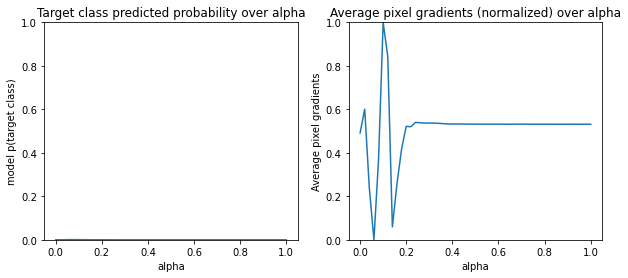

In [562]:
pred = model(interpolated_images.permute(0,3,1,2))
pred_proba = torch.nn.functional.softmax(pred, dim=-1)[:, 555].detach().numpy()

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
# Average across interpolation steps
average_grads = torch.mean(path_gradients, dim=(1, 2, 3))
# Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads - torch.min(average_grads)) / (torch.max(average_grads) - torch.min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
ax2.set_ylim([0, 1]);

### Integral approximation

In [563]:
def integral_approximation(gradients):
    # riemann_trapezoidal
    grads = (gradients[:-1] + gradients[1:]) / 2.0
    integrated_gradients = torch.trapz(grads, dx=1)
    return integrated_gradients

ig = integral_approximation(gradients=path_gradients)
print(ig.shape)

torch.Size([50, 224, 224])


## ALL in one

In [566]:
# def integrated_gradients(baseline, image, target_class_idx, m_steps=50, batch_size=32):
#     alphas = torch.linspace(start=0.0, end=1.0, steps=m_steps+1)

#     # Collect gradients
#     gradient_batches = []

#     # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
#     for alpha in torch.arange(0, len(alphas), batch_size):
#         from_ = alpha
#         to = min(from_ + batch_size, len(alphas))
#         alpha_batch = alphas[int(from_): int(to)]

#         gradient_batch = one_batch(baseline, image, alpha_batch, target_class_idx)
#         gradient_batches.append(gradient_batch)

#     # Concatenate path gradients together row-wise into single tensor.
#     total_gradients = torch.cat(gradient_batches, dim=0)

#     # Integral approximation through averaging gradients.
#     avg_gradients = integral_approximation(gradients=total_gradients)

#     # Scale integrated gradients with respect to input.
#     print(image.shape, image.squeeze(0).permute(1,2,0).shape, baseline.shape)
#     image = image.squeeze(0).permute(1,2,0)
#     integrated_gradients = (image - baseline)
#     integrated_gradients *= avg_gradients

#     return integrated_gradients

# def one_batch(baseline, image, alpha_batch, target_class_idx):
#     # Generate interpolated inputs between baseline and input.
#     interpolated_path_input_batch = interpolate_images(baseline=baseline, image=image, alphas=alpha_batch)

#     # Compute gradients between model outputs and interpolated inputs.
#     gradient_batch = compute_gradients(images=interpolated_path_input_batch, target_class_idx=target_class_idx)
#     return gradient_batch

# ig_attributions = integrated_gradients(baseline=baseline, image=img_name_tensors['Fireboat'], target_class_idx=555, m_steps=240)
# print(ig_attributions.shape)

torch.Size([1, 3, 224, 224]) torch.Size([224, 224, 3]) torch.Size([224, 224, 3])


RuntimeError: The size of tensor a (3) must match the size of tensor b (224) at non-singleton dimension 2